In [1]:
from google.colab import drive
drive.mount('/content/drive')
files_path = '/content/drive/MyDrive/Colab Notebooks/Números MNIST 3 - Tensorflow 2 (no keras)'
!cp '{files_path}/model.py' '/content'
!cp '{files_path}/optimizers.py' '/content'
!cp '{files_path}/export.py' '/content'

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as sk_metrics

import os

from model import Model
from optimizers import GradientDescent, Momentum, Adam
from export import ExportModule

# Refreshing import to changes in utils.py
%load_ext autoreload
%autoreload 2

# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# Set random seed for reproducible results
tf.random.set_seed(22)

2.14.0


In [ ]:
train_data, val_data, test_data = tfds.load("mnist", split=['train[10000:]', 'train[0:10000]', 'test'], as_supervised=True)

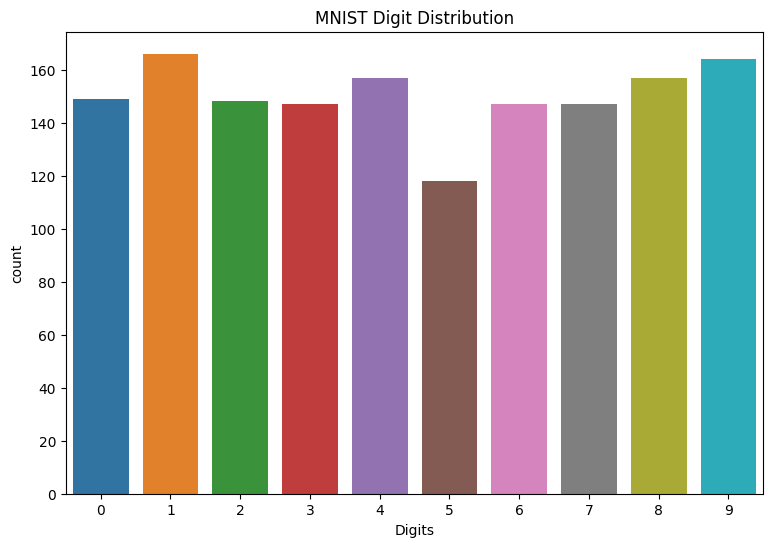

In [ ]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
sns.countplot(x=y_viz.numpy());
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

In [ ]:
for i, j in train_data.take(1):
  print(i.shape, j)

(28, 28, 1) tf.Tensor(7, shape=(), dtype=int64)


In [ ]:
def view_image(ds, use_batch=False):
  if use_batch:
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
  else:
    ds = ds.map(lambda X, y: (X, y))
    image, label = zip(*list(ds.take(20)))

  fig = plt.figure(figsize=(22, 22))
  for i in range(20):
      ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
      ax.imshow(image[i])
      ax.set_title(f"Label: {label[i]}")

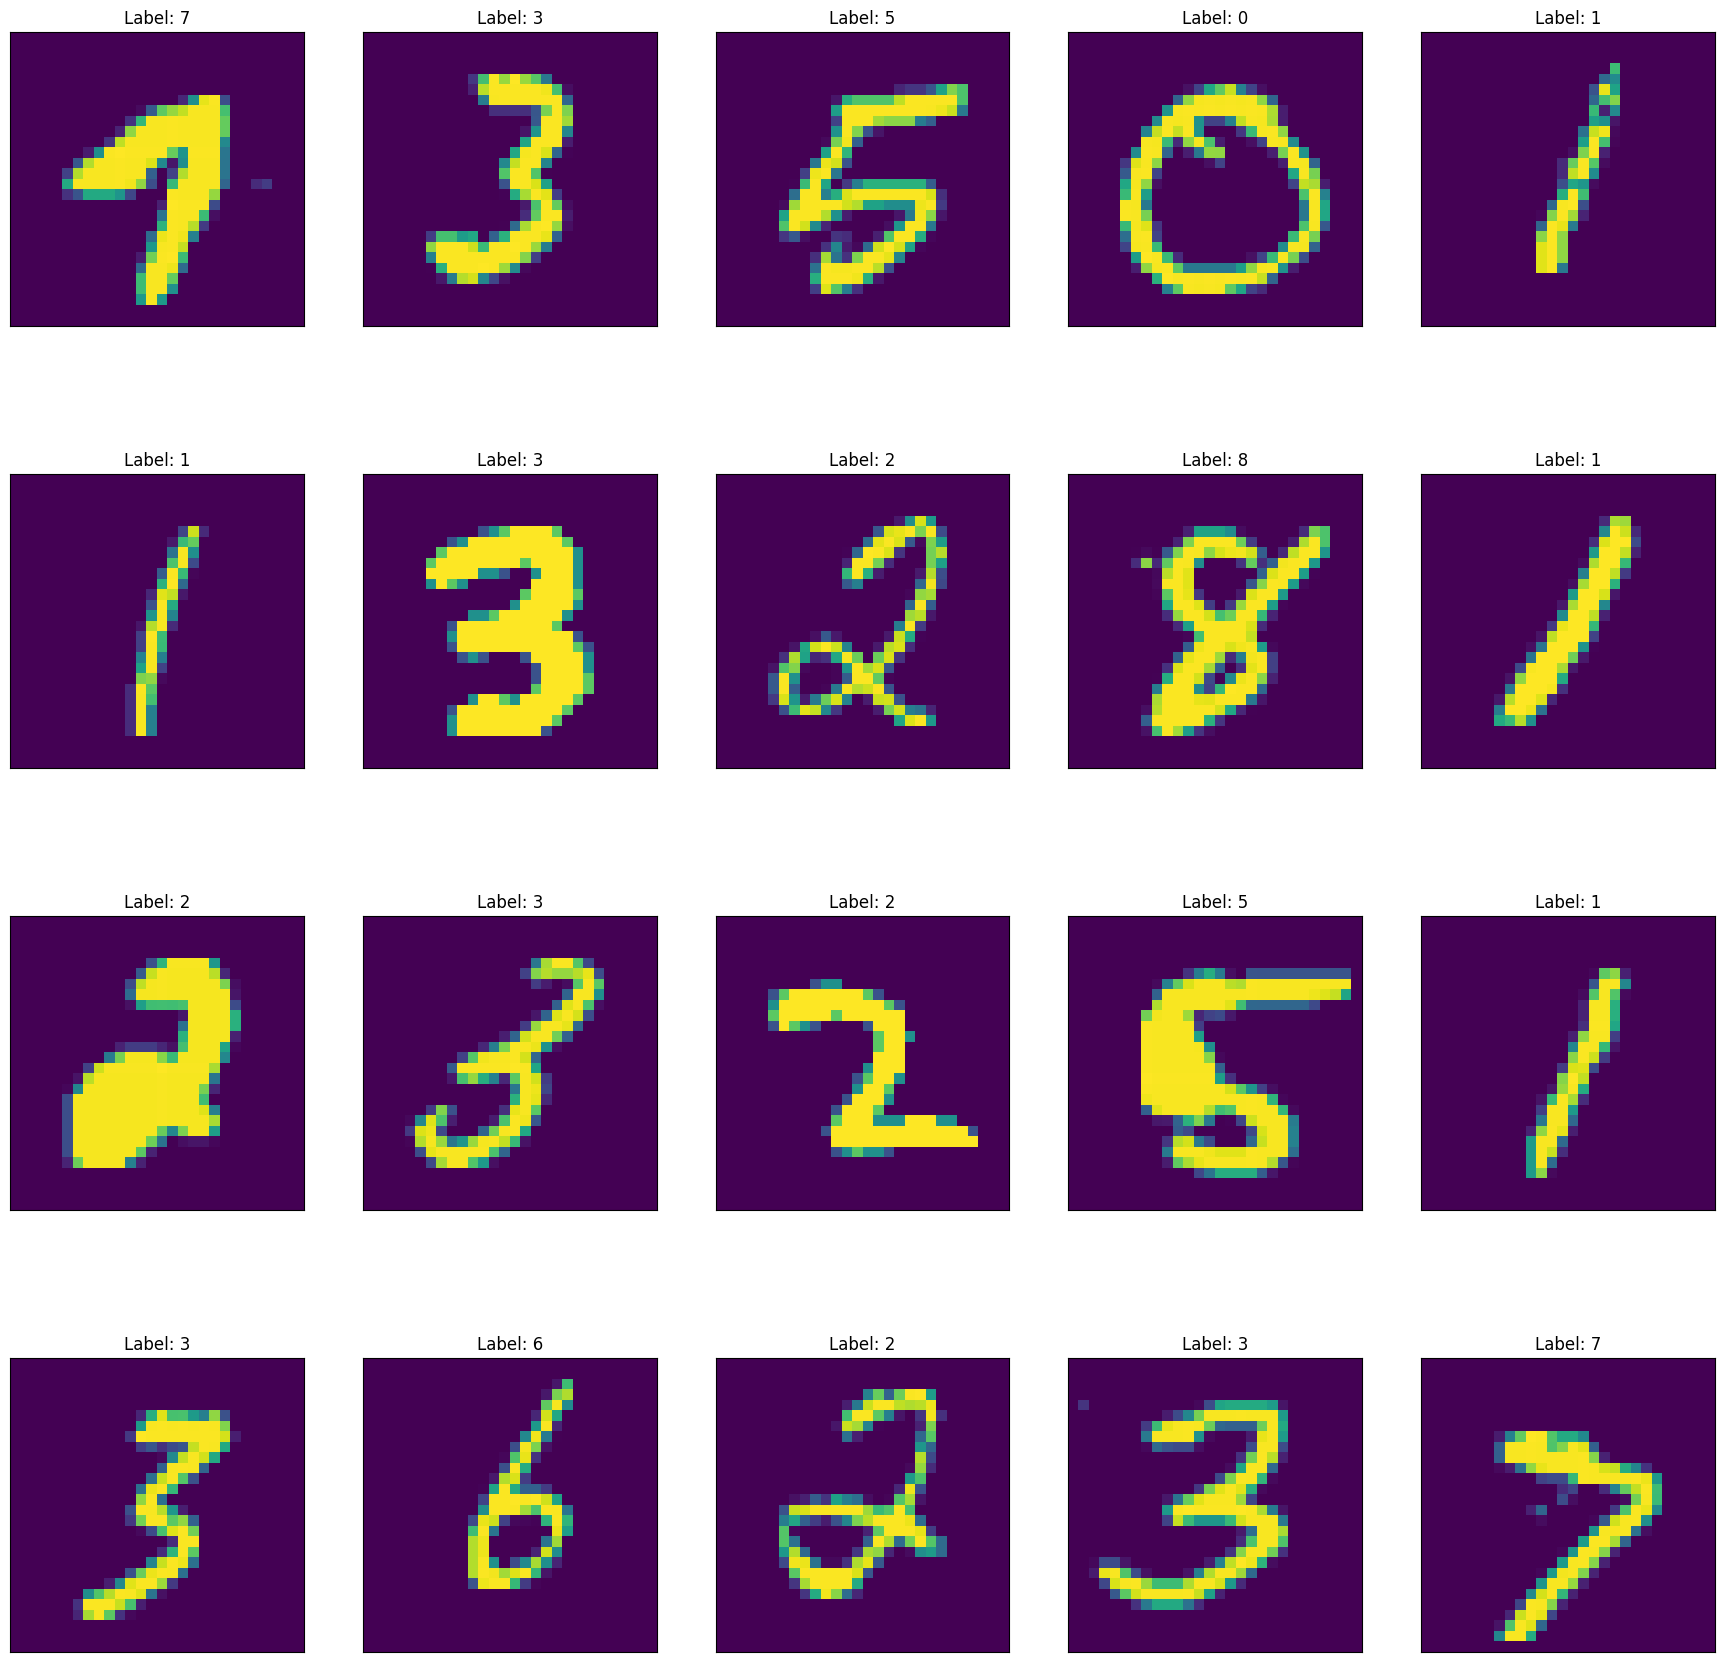

In [ ]:
view_image(train_data)

In [ ]:
data_augmentation = tf.keras.Sequential([
  # tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomTranslation(.2, .2, fill_mode='nearest'),
  tf.keras.layers.RandomRotation(0.2, fill_mode='constant'),
  tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='constant'),
])

In [ ]:
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # normalize all datasets.
  ds = ds.map(lambda x, y: (tf.cast(x, dtype=tf.float32) / 255., y), num_parallel_calls=AUTOTUNE)

  # Use memory instead of disk (faster training)
  ds = ds.cache()

  if shuffle:
    ds = ds.shuffle(len(ds))

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_data = prepare(train_data, shuffle=True, augment=True)
val_data = prepare(val_data)

In [ ]:
for i, j in val_data.take(1):
  print(i.shape, j.shape)

(32, 28, 28, 1) (32,)


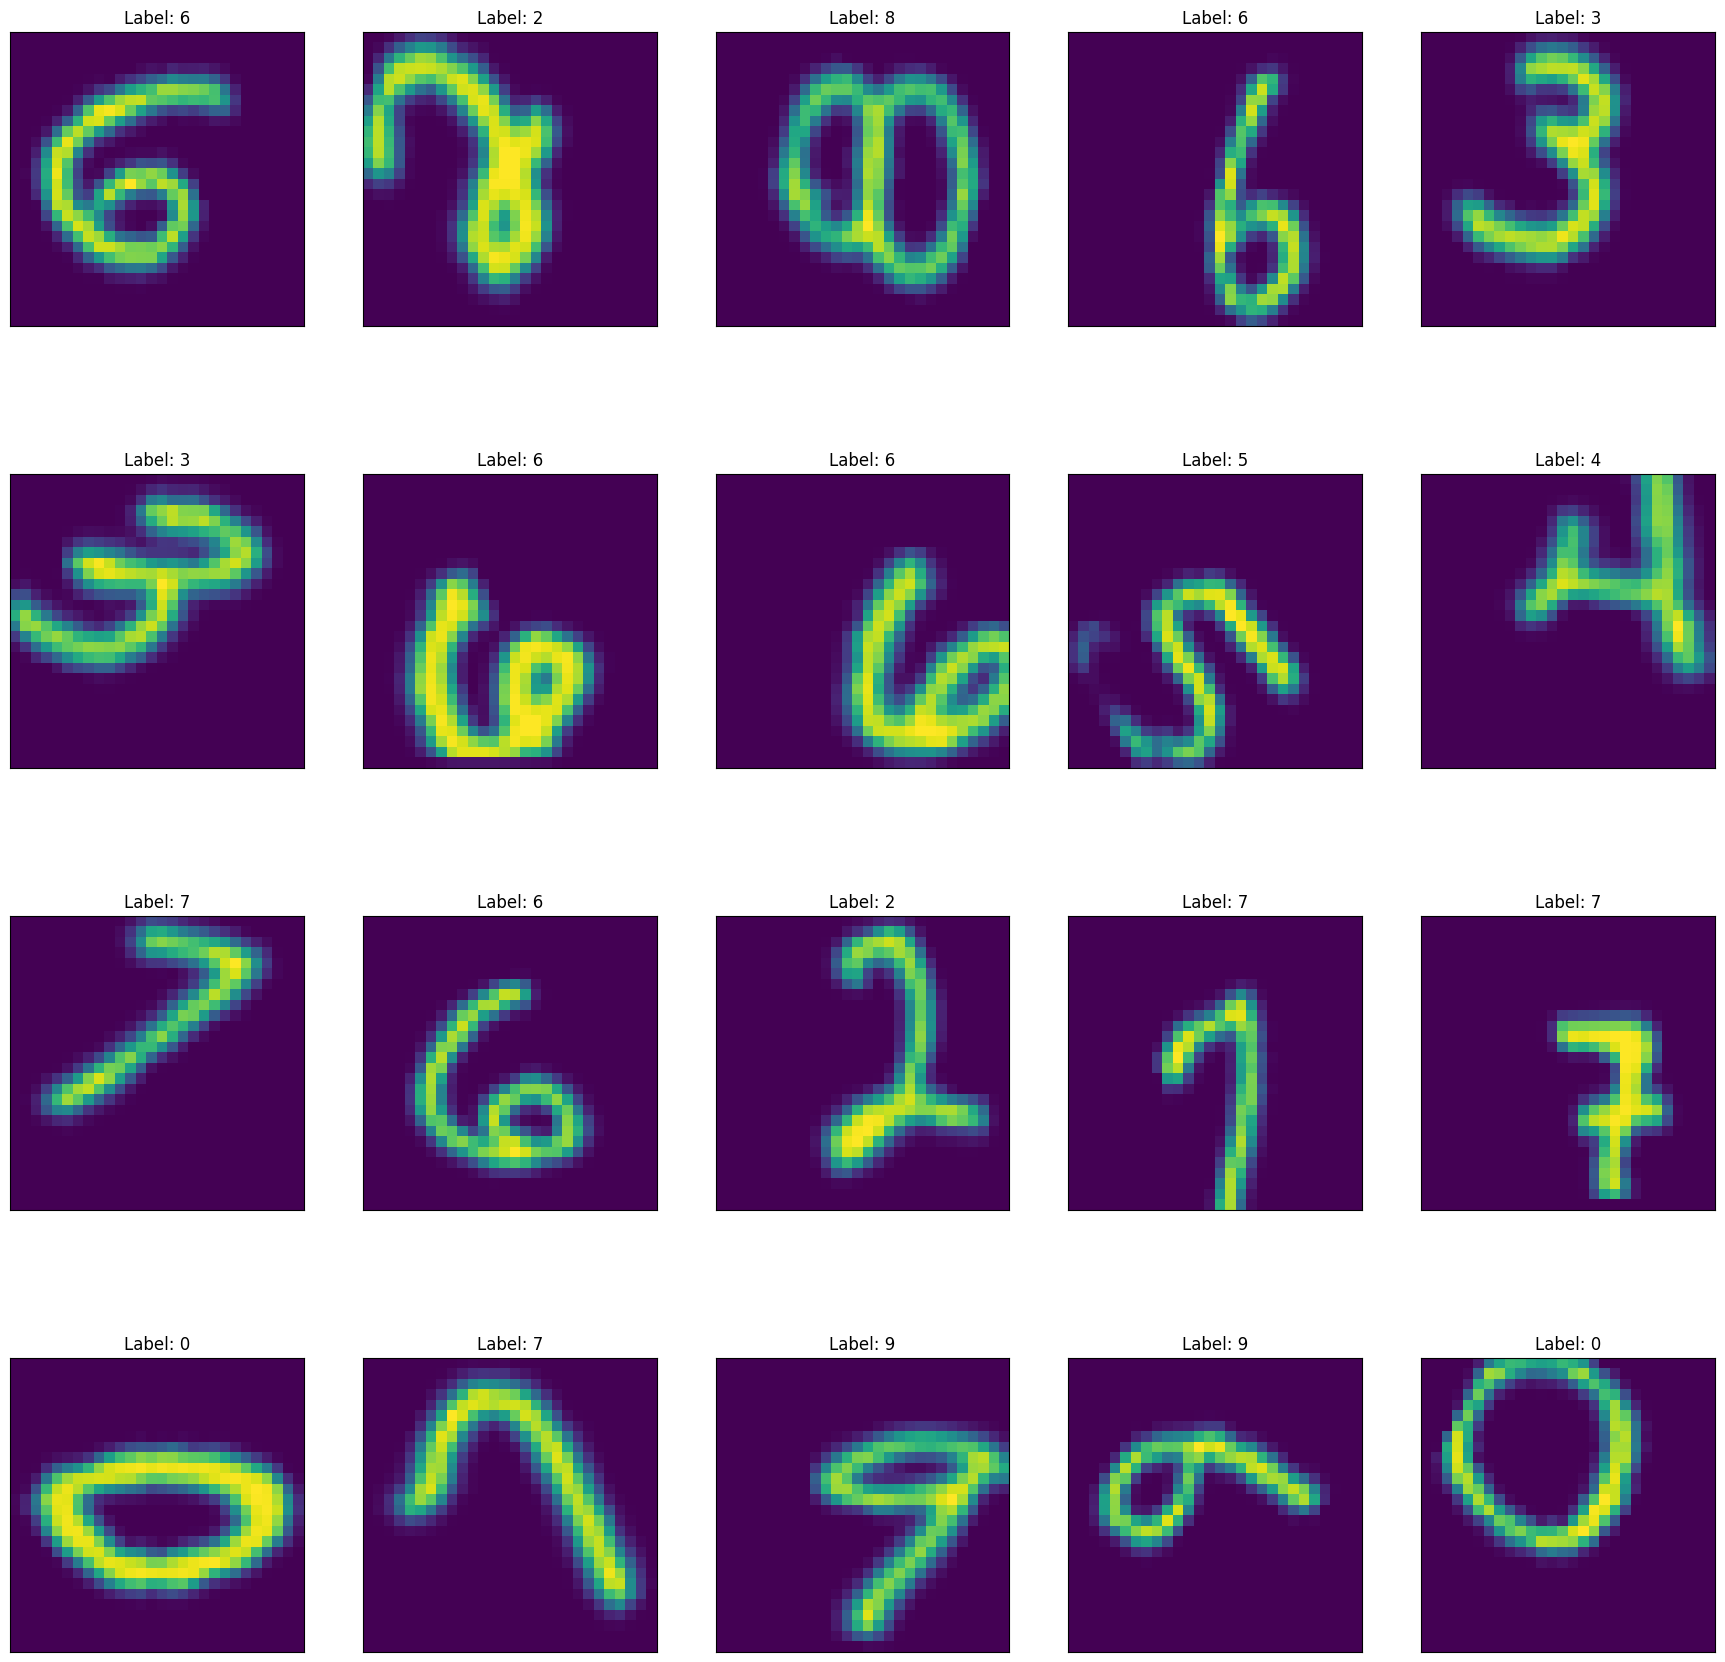

In [ ]:
view_image(train_data, use_batch=True)

In [ ]:
# HYPER PARAMETERS
lr = 1e-3
num_epochs = 30

conv_arch = [32, 64, 128]  # Filters
conv_activation_functions = [tf.nn.relu, tf.nn.relu, tf.nn.relu]
kernel_size = (3, 3)
strides = (1, 1)

fc_arch = [64]  # Neurons
fc_activation_functions = [tf.nn.relu, tf.identity]
fc_input = 1152

model = Model(conv_arch, kernel_size, strides, fc_arch, fc_input, conv_activation_functions, fc_activation_functions)
optimizer = Adam(learning_rate=lr)

loss_list, accuracy_list = [], []
val_loss_list, val_accuracy_list = [], []

print("----------------------------------------")
print(model.title)
print(optimizer.title)
print("----------------------------------------")

# TRAIN MODEL
for epoch in range(num_epochs):

  batch_losses_train, batch_accs_train = [], []
  batch_losses_val, batch_accs_val = [], []

  print("Train Data ", end="")

  # Iterate over the training data
  for i, (X_train_batch, y_train_batch) in enumerate(train_data):
    # Compute gradients and update the model's parameters
    with tf.GradientTape() as t:
      # Batch Loss
      y_pred = model(X_train_batch)
      batch_loss = model.cross_entropy_loss(y_pred, y_train_batch)
    # Batch Accuracy
    batch_acc = model.compute_accuracy(y_pred, y_train_batch)

    grads = t.gradient(batch_loss, model.Variables)

    # Apply Gradients (optimizer)
    model.Variables = optimizer.apply_gradients(model.Variables, grads)

    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  print("[✔] ", end="")

  print("Val Data ", end="")
  # Iterate over the validation data
  for X_val_batch, y_val_batch in val_data:
    # Evaluate the model on given a batch of validation data
    y_pred = model(X_val_batch)
    batch_loss = model.cross_entropy_loss(y_pred, y_val_batch)
    batch_acc = model.compute_accuracy(y_pred, y_val_batch)
    # Keep track of batch-level validation performance
    batch_losses_val.append(batch_loss)
    batch_accs_val.append(batch_acc)

  print("[✔] ", end="")

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)

  loss_list.append(train_loss)
  val_loss_list.append(val_loss)
  accuracy_list.append(train_acc)
  val_accuracy_list.append(val_acc)

  print(f"Epoch: {epoch}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {train_acc:.3f}, Val Accuracy: {val_acc:.3f}")

----------------------------------------
Model architecture:
    Input Image: (batch_size, 28, 28, 1)
    3 Conv Layers: ListWrapper([32, 64, 128])
    1 Dense Layers: ListWrapper([64])
    Output Dense Layer: 10 Neurons
Adam: learning rate = 0.001
----------------------------------------
Train Data [✔] Val Data [✔] Epoch: 0, Loss: 1.3474, Val Loss: 0.4283, Accuracy: 0.532, Val Accuracy: 0.869
Train Data [✔] Val Data [✔] Epoch: 1, Loss: 0.6926, Val Loss: 0.4440, Accuracy: 0.776, Val Accuracy: 0.873
Train Data [✔] Val Data [✔] Epoch: 2, Loss: 0.5328, Val Loss: 0.2516, Accuracy: 0.830, Val Accuracy: 0.924
Train Data [✔] Val Data [✔] Epoch: 3, Loss: 0.4433, Val Loss: 0.2701, Accuracy: 0.857, Val Accuracy: 0.923
Train Data [✔] Val Data [✔] Epoch: 4, Loss: 0.3981, Val Loss: 0.1994, Accuracy: 0.873, Val Accuracy: 0.940
Train Data [✔] Val Data [✔] Epoch: 5, Loss: 0.3582, Val Loss: 0.2065, Accuracy: 0.888, Val Accuracy: 0.942
Train Data [✔] Val Data [✔] Epoch: 6, Loss: 0.3309, Val Loss: 0.2298

**Show Loss and Accuracy**


In [ ]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs");

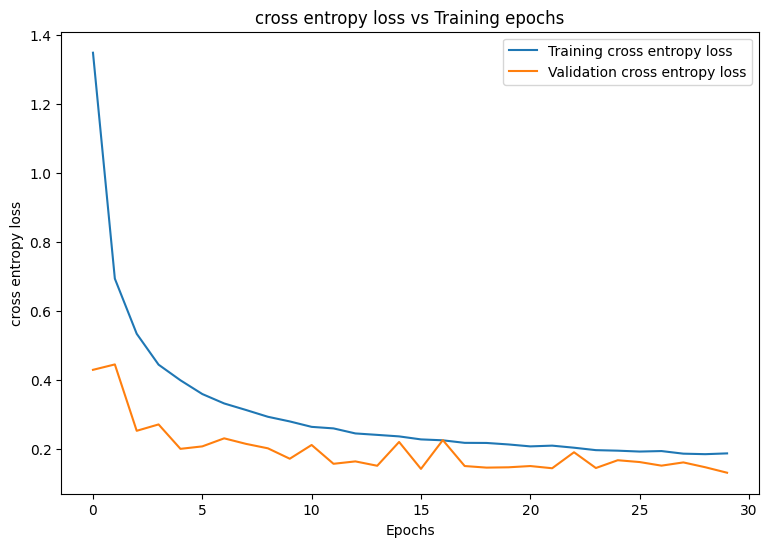

In [ ]:
plot_metrics(loss_list, val_loss_list, "cross entropy loss")

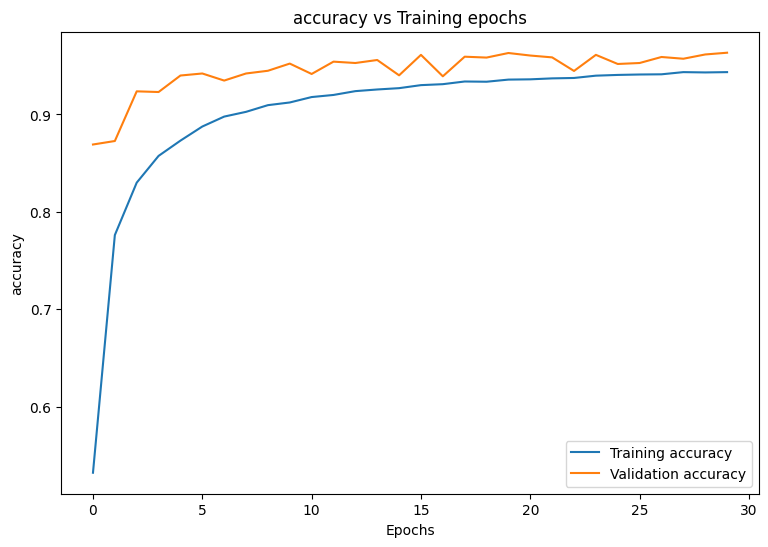

In [ ]:
plot_metrics(accuracy_list, val_accuracy_list, "accuracy")

**Save and Load Model**

In [ ]:
def preprocess_test(x):
  # The export module takes in unprocessed and unlabeled data
  x = x/255
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)

In [ ]:
mnist_model_export = ExportModule(model=model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [ ]:
path = files_path + '/models'
save_path = os.path.join(path, 'mlp_model_export2')
tf.saved_model.save(mnist_model_export, save_path)

In [ ]:
mnist_loaded = tf.saved_model.load(save_path)

In [ ]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mnist_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.962


In [ ]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 7: 0.905
Digit 9: 0.951
Digit 8: 0.959
Digit 4: 0.960
Digit 1: 0.961
Digit 6: 0.965
Digit 0: 0.978
Digit 5: 0.978
Digit 2: 0.979
Digit 3: 0.990


**Confusion Matrix**

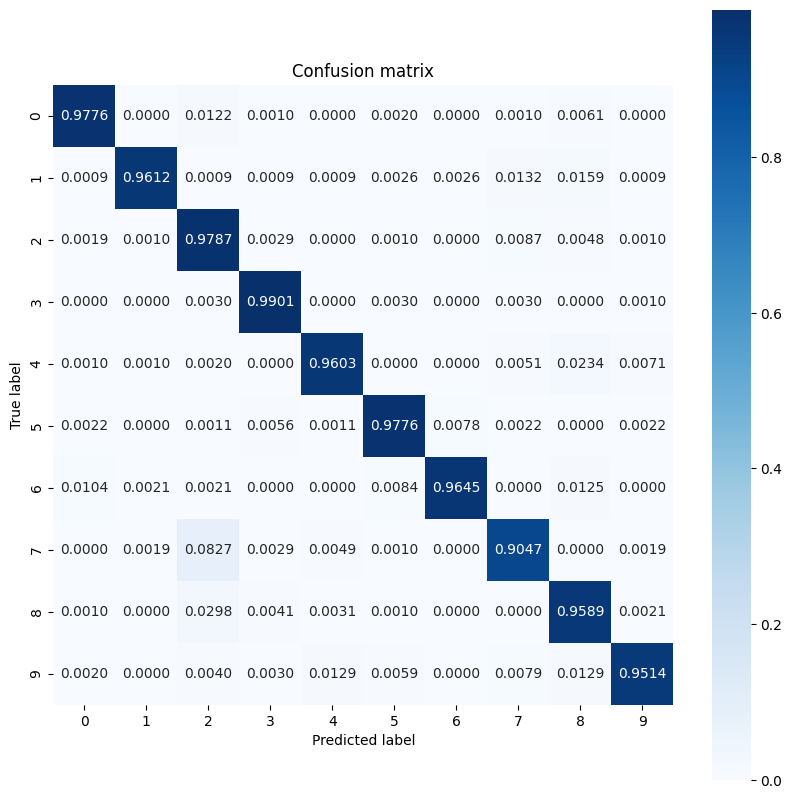

In [ ]:
def show_confusion_matrix(test_labels, test_classes):
  # Compute confusion matrix and normalize
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels.numpy(),
                                          test_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(10)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(y_test, test_classes)

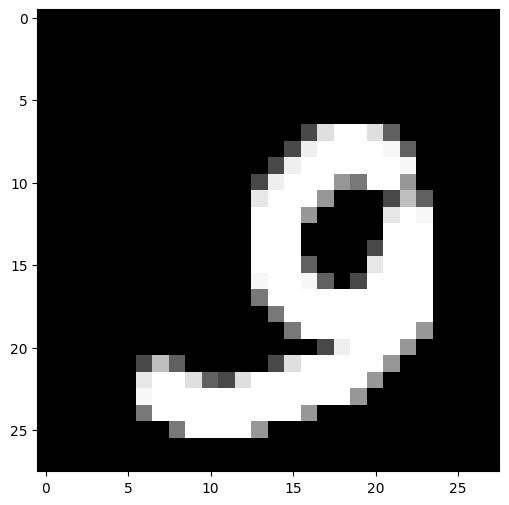

In [ ]:
import cv2

# Leer una imagen
img = cv2.imread("/content/9.png")
img = tf.image.rgb_to_grayscale(img)
imagen_invertida = 255 - img[:, :, 0]
imagen_invertida = tf.expand_dims(imagen_invertida, axis=-1)
plt.imshow(imagen_invertida, cmap='gray')
imagen_invertida = tf.expand_dims(imagen_invertida, axis=0)

In [ ]:
prediction = mnist_loaded(imagen_invertida)
prediction.numpy()

array([9])